In [ ]:
### USANDO O GOOGLE COLAB PARA BAIXAR O DATASET

import os

# Baixa o arquivo do Google Drive
!gdown 1MvvLoQzUbodQQ-eOCHU89LwX44gWxDgq -O utkface.zip

# Descompacta o zip
!unzip -q utkface.zip

# Descompacta o tar.gz
tar_path = '/content/fer2013.tar.gz'
extract_path = '/content/fer2013'
os.makedirs(extract_path, exist_ok=True)
!tar -xzf {tar_path} -C {extract_path}

# Caminho do CSV
csv_path = os.path.join(extract_path, 'fer2013/fer2013.csv')

In [ ]:
import pandas as pd

data = pd.read_csv(csv_path)

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Função de pré-processamento
def preprocess_data(data):
    pixels = data['pixels'].tolist()
    faces = [np.fromstring(pixel_sequence, dtype=int, sep=' ').reshape(48, 48, 1) for pixel_sequence in pixels]
    faces = np.array(faces).astype('float32')
    faces /= 255.0
    emotions = to_categorical(data['emotion'], num_classes=7)
    return faces, emotions

# Separar os dados de treinamento, validação e teste
train_data = data[data['Usage'] == 'Training']
val_data = data[data['Usage'] == 'PublicTest']
test_data = data[data['Usage'] == 'PrivateTest']

x_train, y_train = preprocess_data(train_data)
x_val, y_val = preprocess_data(val_data)
x_test, y_test = preprocess_data(test_data)

# Verificar as formas dos dados
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (28709, 48, 48, 1)
y_train shape: (28709, 7)
x_val shape: (3589, 48, 48, 1)
y_val shape: (3589, 7)
x_test shape: (3589, 48, 48, 1)
y_test shape: (3589, 7)


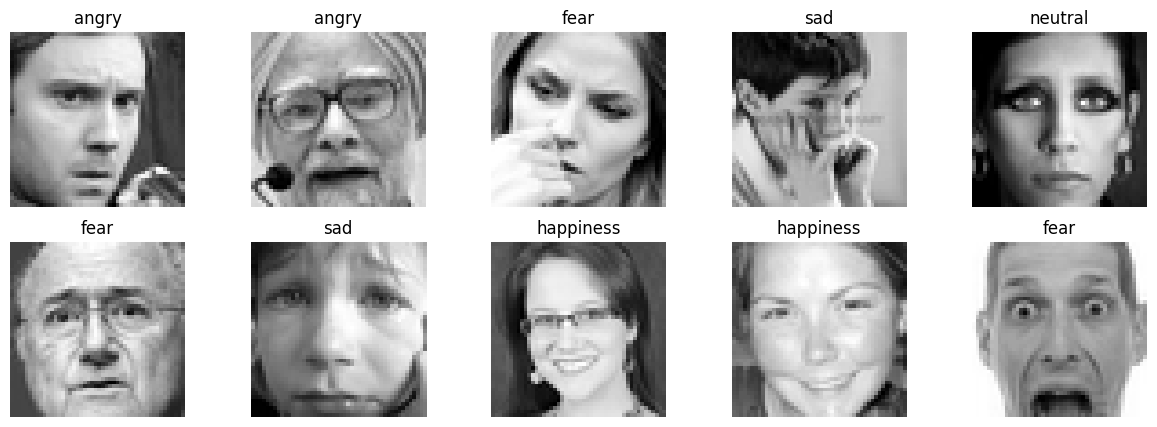

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Dicionário para mapear índices de emoção para rótulos textuais
label_to_text = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sad', 5: 'surprise', 6: 'neutral'}

# Função para exibir algumas imagens do dataset
def show_sample_images(faces, emotions, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(faces[i].reshape(48, 48), cmap='gray')
        plt.title(label_to_text[np.argmax(emotions[i])])
        plt.axis('off')
    plt.show()

# Exibir 10 imagens de exemplo do conjunto de treinamento
show_sample_images(x_train, y_train, num_images=10)



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Criar geradores de dados
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Criar geradores
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=64)
test_generator = test_datagen.flow(x_test, y_test, batch_size=64)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([

    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(255, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Treinamento do modelo usando geradores
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 64,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_val) // 64,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2316 - loss: 1.8410

448/448 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.2317 - loss: 1.8409 - val_accuracy: 0.2489 - val_loss: 1.7968 - learning_rate: 0.0010
Epoch 2/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2969 - loss: 1.7708

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.2969 - loss: 1.7708 - val_accuracy: 0.2486 - val_loss: 1.7968 - learning_rate: 0.0010
Epoch 3/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2533 - loss: 1.8024

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2533 - loss: 1.8024 - val_accuracy: 0.2606 - val_loss: 1.7812 - learning_rate: 0.0010
Epoch 4/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.2812 - loss: 1.7220 - val_accuracy: 0.2592 - val_loss: 1.7813 - learning_rate: 0.0010
Epoch 5/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2519 - loss: 1.7956

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.2519 - loss: 1.7956 - val_accuracy: 0.2734 - val_loss: 1.7686 - learning_rate: 0.0010
Epoch 6/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2656 - loss: 1.7674

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.2656 - loss: 1.7674 - val_accuracy: 0.2693 - val_loss: 1.7665 - learning_rate: 0.0010
Epoch 7/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2581 - loss: 1.7811

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2581 - loss: 1.7811 - val_accuracy: 0.3064 - val_loss: 1.7246 - learning_rate: 0.0010
Epoch 8/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2188 - loss: 1.7671

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.2188 - loss: 1.7671 - val_accuracy: 0.3058 - val_loss: 1.7240 - learning_rate: 0.0010
Epoch 9/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2694 - loss: 1.7648

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2694 - loss: 1.7648 - val_accuracy: 0.3078 - val_loss: 1.6776 - learning_rate: 0.0010
Epoch 10/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.2969 - loss: 1.7628 - val_accuracy: 0.3114 - val_loss: 1.6825 - learning_rate: 0.0010
Epoch 11/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2817 - loss: 1.7338

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2817 - loss: 1.7338 - val_accuracy: 0.3404 - val_loss: 1.6429 - learning_rate: 0.0010
Epoch 12/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.2969 - loss: 1.7480 - val_accuracy: 0.3379 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 13/500
446/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2946 - loss: 1.7198

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.2947 - loss: 1.7198 - val_accuracy: 0.3334 - val_loss: 1.6414 - learning_rate: 0.0010
Epoch 14/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3281 - loss: 1.7200

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.3281 - loss: 1.7200 - val_accuracy: 0.3438 - val_loss: 1.6309 - learning_rate: 0.0010
Epoch 15/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3049 - loss: 1.6943

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3049 - loss: 1.6942 - val_accuracy: 0.3736 - val_loss: 1.5558 - learning_rate: 0.0010
Epoch 16/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2812 - loss: 1.7498

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.2812 - loss: 1.7498 - val_accuracy: 0.3842 - val_loss: 1.5515 - learning_rate: 0.0010
Epoch 17/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3359 - loss: 1.6607

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3359 - loss: 1.6607 - val_accuracy: 0.4174 - val_loss: 1.4809 - learning_rate: 0.0010
Epoch 18/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.3438 - loss: 1.6901 - val_accuracy: 0.4169 - val_loss: 1.4821 - learning_rate: 0.0010
Epoch 19/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3635 - loss: 1.6056

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3635 - loss: 1.6056 - val_accuracy: 0.4562 - val_loss: 1.4127 - learning_rate: 0.0010
Epoch 20/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4219 - loss: 1.4722

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.4219 - loss: 1.4722 - val_accuracy: 0.4579 - val_loss: 1.4106 - learning_rate: 0.0010
Epoch 21/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3798 - loss: 1.5749

448/448 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3798 - loss: 1.5749 - val_accuracy: 0.4754 - val_loss: 1.3532 - learning_rate: 0.0010
Epoch 22/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.3906 - loss: 1.4922 - val_accuracy: 0.4704 - val_loss: 1.3552 - learning_rate: 0.0010
Epoch 23/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4017 - loss: 1.5345

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4017 - loss: 1.5345 - val_accuracy: 0.4760 - val_loss: 1.3469 - learning_rate: 0.0010
Epoch 24/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.4219 - loss: 1.5386 - val_accuracy: 0.4766 - val_loss: 1.3475 - learning_rate: 0.0010
Epoch 25/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4209 - loss: 1.5013

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4208 - loss: 1.5013 - val_accuracy: 0.4830 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 26/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4688 - loss: 1.3883

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.4688 - loss: 1.3883 - val_accuracy: 0.4858 - val_loss: 1.3172 - learning_rate: 0.0010
Epoch 27/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4228 - loss: 1.4874

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4228 - loss: 1.4874 - val_accuracy: 0.4967 - val_loss: 1.3062 - learning_rate: 0.0010
Epoch 28/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.4531 - loss: 1.4086 - val_accuracy: 0.4908 - val_loss: 1.3116 - learning_rate: 0.0010
Epoch 29/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4273 - loss: 1.4789

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4273 - loss: 1.4789 - val_accuracy: 0.5075 - val_loss: 1.2880 - learning_rate: 0.0010
Epoch 30/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.2969 - loss: 1.5920 - val_accuracy: 0.5050 - val_loss: 1.2881 - learning_rate: 0.0010
Epoch 31/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4367 - loss: 1.4683 - val_accuracy: 0.4947 - val_loss: 1.3114 - learning_rate: 0.0010
Epoch 32/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.5000 - loss: 1.3740 - val_accuracy: 0.4972 - val_loss: 1.3071 - learning_rate: 0.0010
Epoch 33/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4449 - loss: 1.4461

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4449 - loss: 1.4461 - val_accuracy: 0.5042 - val_loss: 1.2732 - learning_rate: 0.0010
Epoch 34/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.5000 - loss: 1.4909 - val_accuracy: 0.5047 - val_loss: 1.2743 - learning_rate: 0.0010
Epoch 35/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4414 - loss: 1.4490

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4414 - loss: 1.4490 - val_accuracy: 0.5162 - val_loss: 1.2642 - learning_rate: 0.0010
Epoch 36/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3750 - loss: 1.5260

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.3750 - loss: 1.5260 - val_accuracy: 0.5181 - val_loss: 1.2631 - learning_rate: 0.0010
Epoch 37/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4570 - loss: 1.4247

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4570 - loss: 1.4247 - val_accuracy: 0.5134 - val_loss: 1.2589 - learning_rate: 0.0010
Epoch 38/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5312 - loss: 1.2810

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.5312 - loss: 1.2810 - val_accuracy: 0.5145 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 39/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4542 - loss: 1.4290

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4542 - loss: 1.4290 - val_accuracy: 0.5137 - val_loss: 1.2540 - learning_rate: 0.0010
Epoch 40/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5469 - loss: 1.2792

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.5469 - loss: 1.2792 - val_accuracy: 0.5170 - val_loss: 1.2508 - learning_rate: 0.0010
Epoch 41/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4572 - loss: 1.4035

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4572 - loss: 1.4036 - val_accuracy: 0.5220 - val_loss: 1.2319 - learning_rate: 0.0010
Epoch 42/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3906 - loss: 1.5330

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.3906 - loss: 1.5330 - val_accuracy: 0.5257 - val_loss: 1.2291 - learning_rate: 0.0010
Epoch 43/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4603 - loss: 1.4033 - val_accuracy: 0.5193 - val_loss: 1.2364 - learning_rate: 0.0010
Epoch 44/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.3281 - loss: 1.4966 - val_accuracy: 0.5193 - val_loss: 1.2332 - learning_rate: 0.0010
Epoch 45/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4624 - loss: 1.4050

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4624 - loss: 1.4050 - val_accuracy: 0.5187 - val_loss: 1.2288 - learning_rate: 0.0010
Epoch 46/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.5781 - loss: 1.2230 - val_accuracy: 0.5195 - val_loss: 1.2291 - learning_rate: 0.0010
Epoch 47/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4648 - loss: 1.3957

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4648 - loss: 1.3957 - val_accuracy: 0.5312 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 48/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.4062 - loss: 1.5087 - val_accuracy: 0.5290 - val_loss: 1.2296 - learning_rate: 0.0010
Epoch 49/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4677 - loss: 1.3843

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4677 - loss: 1.3843 - val_accuracy: 0.5360 - val_loss: 1.1992 - learning_rate: 0.0010
Epoch 50/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5156 - loss: 1.2925

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5156 - loss: 1.2925 - val_accuracy: 0.5360 - val_loss: 1.1984 - learning_rate: 0.0010
Epoch 51/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4709 - loss: 1.3880

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4709 - loss: 1.3880 - val_accuracy: 0.5449 - val_loss: 1.1979 - learning_rate: 0.0010
Epoch 52/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.4844 - loss: 1.7526 - val_accuracy: 0.5463 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 53/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4784 - loss: 1.3806 - val_accuracy: 0.5382 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 54/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.5312 - loss: 1.3241 - val_accuracy: 0.5377 - val_loss: 1.2000 - learning_rate: 0.0010
Epoch 55/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4721 - loss: 1.3732 - val_accuracy: 0.5315 - val_loss: 1.2094 - learning_rate: 0.0010
Epoch 56/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.4375 - loss: 1.3556 - val_accuracy: 0.5301 - val_loss: 1.2099 - learning_rate: 0.0010
Epoch 57/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4763 - l

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4763 - loss: 1.3681 - val_accuracy: 0.5405 - val_loss: 1.1971 - learning_rate: 0.0010
Epoch 58/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.4375 - loss: 1.5089 - val_accuracy: 0.5405 - val_loss: 1.2037 - learning_rate: 0.0010
Epoch 59/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4783 - loss: 1.3689 - val_accuracy: 0.5382 - val_loss: 1.2070 - learning_rate: 0.0010
Epoch 60/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.3906 - loss: 1.5061 - val_accuracy: 0.5371 - val_loss: 1.2083 - learning_rate: 0.0010
Epoch 61/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4899 - loss: 1.3485

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4899 - loss: 1.3485 - val_accuracy: 0.5444 - val_loss: 1.1810 - learning_rate: 0.0010
Epoch 62/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4844 - loss: 1.3667

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.4844 - loss: 1.3667 - val_accuracy: 0.5463 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 63/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4854 - loss: 1.3486 - val_accuracy: 0.5366 - val_loss: 1.1987 - learning_rate: 0.0010
Epoch 64/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.3906 - loss: 1.4372 - val_accuracy: 0.5366 - val_loss: 1.1986 - learning_rate: 0.0010
Epoch 65/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4824 - loss: 1.3554 - val_accuracy: 0.5416 - val_loss: 1.2121 - learning_rate: 0.0010
Epoch 66/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.5938 - loss: 1.3561 - val_accuracy: 0.5416 - val_loss: 1.2089 - learning_rate: 0.0010
Epoch 67/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4826 - loss: 1.3587

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4826 - loss: 1.3586 - val_accuracy: 0.5480 - val_loss: 1.1722 - learning_rate: 0.0010
Epoch 68/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.4375 - loss: 1.3768 - val_accuracy: 0.5446 - val_loss: 1.1758 - learning_rate: 0.0010
Epoch 69/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4894 - loss: 1.3464 - val_accuracy: 0.5458 - val_loss: 1.1875 - learning_rate: 0.0010
Epoch 70/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.5156 - loss: 1.4458 - val_accuracy: 0.5485 - val_loss: 1.1861 - learning_rate: 0.0010
Epoch 71/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4850 - loss: 1.3472 - val_accuracy: 0.5522 - val_loss: 1.1787 - learning_rate: 0.0010
Epoch 72/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.5312 - loss: 1.2559 - val_accuracy: 0.5539 - val_loss: 1.1793 - learning_rate: 0.0010
Epoch 73/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4888 - l

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4888 - loss: 1.3481 - val_accuracy: 0.5527 - val_loss: 1.1647 - learning_rate: 0.0010
Epoch 74/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5312 - loss: 1.3610

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5312 - loss: 1.3610 - val_accuracy: 0.5544 - val_loss: 1.1634 - learning_rate: 0.0010
Epoch 75/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4935 - loss: 1.3302

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4935 - loss: 1.3301 - val_accuracy: 0.5578 - val_loss: 1.1531 - learning_rate: 0.0010
Epoch 76/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.5625 - loss: 1.2465 - val_accuracy: 0.5580 - val_loss: 1.1550 - learning_rate: 0.0010
Epoch 77/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4902 - loss: 1.3386

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4902 - loss: 1.3386 - val_accuracy: 0.5647 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 78/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.5312 - loss: 1.2438 - val_accuracy: 0.5647 - val_loss: 1.1551 - learning_rate: 0.0010
Epoch 79/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4989 - loss: 1.3207 - val_accuracy: 0.5611 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 80/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.5312 - loss: 1.3652 - val_accuracy: 0.5608 - val_loss: 1.1568 - learning_rate: 0.0010
Epoch 81/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4939 - loss: 1.3305 - val_accuracy: 0.5572 - val_loss: 1.1630 - learning_rate: 0.0010
Epoch 82/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.4531 - loss: 1.4783 - val_accuracy: 0.5552 - val_loss: 1.1636 - learning_rate: 0.0010
Epoch 83/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4932 - 

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5050 - loss: 1.3185 - val_accuracy: 0.5653 - val_loss: 1.1437 - learning_rate: 0.0010
Epoch 86/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5938 - loss: 1.2073

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.5938 - loss: 1.2073 - val_accuracy: 0.5636 - val_loss: 1.1437 - learning_rate: 0.0010
Epoch 87/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.4969 - loss: 1.3222 - val_accuracy: 0.5664 - val_loss: 1.1506 - learning_rate: 0.0010
Epoch 88/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.5000 - loss: 1.4272 - val_accuracy: 0.5695 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 89/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4974 - loss: 1.3223 - val_accuracy: 0.5597 - val_loss: 1.1438 - learning_rate: 0.0010
Epoch 90/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5938 - loss: 1.0789

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.5938 - loss: 1.0789 - val_accuracy: 0.5569 - val_loss: 1.1417 - learning_rate: 0.0010
Epoch 91/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4996 - loss: 1.3272 - val_accuracy: 0.5575 - val_loss: 1.1460 - learning_rate: 0.0010
Epoch 92/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.4062 - loss: 1.3718 - val_accuracy: 0.5594 - val_loss: 1.1474 - learning_rate: 0.0010
Epoch 93/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4977 - loss: 1.3195 - val_accuracy: 0.5681 - val_loss: 1.1482 - learning_rate: 0.0010
Epoch 94/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.4375 - loss: 1.4178 - val_accuracy: 0.5686 - val_loss: 1.1498 - learning_rate: 0.0010
Epoch 95/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5098 - loss: 1.3130 - val_accuracy: 0.5639 - val_loss: 1.1609 - learning_rate: 0.0010
Epoch 96/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.4844 - 

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5083 - loss: 1.3042 - val_accuracy: 0.5670 - val_loss: 1.1373 - learning_rate: 0.0010
Epoch 98/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.5676 - loss: 1.3522 - val_accuracy: 0.5647 - val_loss: 1.1381 - learning_rate: 0.0010
Epoch 99/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5038 - loss: 1.3107

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5038 - loss: 1.3107 - val_accuracy: 0.5778 - val_loss: 1.1338 - learning_rate: 0.0010
Epoch 100/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4688 - loss: 1.4680 - val_accuracy: 0.5801 - val_loss: 1.1360 - learning_rate: 0.0010
Epoch 101/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5066 - loss: 1.3098 - val_accuracy: 0.5614 - val_loss: 1.1417 - learning_rate: 0.0010
Epoch 102/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.4844 - loss: 1.2748 - val_accuracy: 0.5628 - val_loss: 1.1407 - learning_rate: 0.0010
Epoch 103/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5089 - loss: 1.3076 - val_accuracy: 0.5558 - val_loss: 1.1589 - learning_rate: 0.0010
Epoch 104/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.4688 - loss: 1.3199 - val_accuracy: 0.5533 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 105/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5096 - loss: 1.3022 - val_accuracy: 0.5723 - val_loss: 1.1293 - learning_rate: 0.0010
Epoch 108/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4531 - loss: 1.2126

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.4531 - loss: 1.2126 - val_accuracy: 0.5700 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 109/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5091 - loss: 1.2975

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5091 - loss: 1.2975 - val_accuracy: 0.5642 - val_loss: 1.1267 - learning_rate: 0.0010
Epoch 110/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.4219 - loss: 1.4107 - val_accuracy: 0.5614 - val_loss: 1.1277 - learning_rate: 0.0010
Epoch 111/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5069 - loss: 1.3058 - val_accuracy: 0.5678 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 112/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6250 - loss: 1.0984 - val_accuracy: 0.5672 - val_loss: 1.1361 - learning_rate: 0.0010
Epoch 113/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5134 - loss: 1.2914

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5134 - loss: 1.2914 - val_accuracy: 0.5670 - val_loss: 1.1131 - learning_rate: 0.0010
Epoch 114/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.3594 - loss: 1.4330 - val_accuracy: 0.5658 - val_loss: 1.1151 - learning_rate: 0.0010
Epoch 115/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5129 - loss: 1.2867 - val_accuracy: 0.5742 - val_loss: 1.1205 - learning_rate: 0.0010
Epoch 116/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.4375 - loss: 1.3622 - val_accuracy: 0.5717 - val_loss: 1.1190 - learning_rate: 0.0010
Epoch 117/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5125 - loss: 1.2864 - val_accuracy: 0.5711 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 118/500
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3594 - loss: 1.6869

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.3594 - loss: 1.6869 - val_accuracy: 0.5714 - val_loss: 1.1121 - learning_rate: 0.0010
Epoch 119/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5133 - loss: 1.2935 - val_accuracy: 0.5706 - val_loss: 1.1265 - learning_rate: 0.0010
Epoch 120/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.5312 - loss: 1.3436 - val_accuracy: 0.5720 - val_loss: 1.1277 - learning_rate: 0.0010
Epoch 121/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5169 - loss: 1.2861 - val_accuracy: 0.5714 - val_loss: 1.1316 - learning_rate: 0.0010
Epoch 122/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.4844 - loss: 1.3687 - val_accuracy: 0.5695 - val_loss: 1.1366 - learning_rate: 0.0010
Epoch 123/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5206 - loss: 1.2850 - val_accuracy: 0.5583 - val_loss: 1.1430 - learning_rate: 0.0010
Epoch 124/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.3

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5128 - loss: 1.2846 - val_accuracy: 0.5698 - val_loss: 1.1109 - learning_rate: 0.0010
Epoch 126/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.5625 - loss: 1.2036 - val_accuracy: 0.5695 - val_loss: 1.1115 - learning_rate: 0.0010
Epoch 127/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5143 - loss: 1.2927 - val_accuracy: 0.5717 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 128/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.5781 - loss: 1.2078 - val_accuracy: 0.5695 - val_loss: 1.1210 - learning_rate: 0.0010
Epoch 129/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5182 - loss: 1.2823 - val_accuracy: 0.5723 - val_loss: 1.1224 - learning_rate: 0.0010
Epoch 130/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.4531 - loss: 1.3808 - val_accuracy: 0.5720 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 131/500
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.51

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5169 - loss: 1.2837 - val_accuracy: 0.5795 - val_loss: 1.1088 - learning_rate: 0.0010
Epoch 132/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.4062 - loss: 1.4958 - val_accuracy: 0.5767 - val_loss: 1.1112 - learning_rate: 0.0010
Epoch 133/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5172 - loss: 1.2839 - val_accuracy: 0.5709 - val_loss: 1.1382 - learning_rate: 0.0010
Epoch 134/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.5312 - loss: 1.3565 - val_accuracy: 0.5653 - val_loss: 1.1435 - learning_rate: 0.0010
Epoch 135/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5192 - loss: 1.2753 - val_accuracy: 0.5714 - val_loss: 1.1158 - learning_rate: 0.0010
Epoch 136/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5156 - loss: 1.2716 - val_accuracy: 0.5714 - val_loss: 1.1166 - learning_rate: 0.0010
Epoch 137/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.52

448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5239 - loss: 1.2672 - val_accuracy: 0.5770 - val_loss: 1.1055 - learning_rate: 0.0010
Epoch 138/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.5625 - loss: 1.2348 - val_accuracy: 0.5778 - val_loss: 1.1058 - learning_rate: 0.0010
Epoch 139/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5188 - loss: 1.2736 - val_accuracy: 0.5561 - val_loss: 1.1608 - learning_rate: 0.0010
Epoch 140/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5000 - loss: 1.1921 - val_accuracy: 0.5550 - val_loss: 1.1614 - learning_rate: 0.0010
Epoch 141/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5257 - loss: 1.2709 - val_accuracy: 0.5737 - val_loss: 1.1286 - learning_rate: 0.0010
Epoch 142/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.5469 - loss: 1.2749 - val_accuracy: 0.5748 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 143/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.5312 - loss: 1.2941 - val_accuracy: 0.5787 - val_loss: 1.1048 - learning_rate: 0.0010
Epoch 145/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5225 - loss: 1.2763 - val_accuracy: 0.5742 - val_loss: 1.1179 - learning_rate: 0.0010
Epoch 146/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.5469 - loss: 1.2302 - val_accuracy: 0.5725 - val_loss: 1.1173 - learning_rate: 0.0010
Epoch 147/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5181 - loss: 1.2888 - val_accuracy: 0.5689 - val_loss: 1.1259 - learning_rate: 0.0010
Epoch 148/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5781 - loss: 1.2177 - val_accuracy: 0.5698 - val_loss: 1.1240 - learning_rate: 0.0010
Epoch 149/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5199 - loss: 1.2727 - val_accuracy: 0.5751 - val_loss: 1.1111 - learning_rate: 0.0010
Epoch 150/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.5

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.5625 - loss: 1.2851 - val_accuracy: 0.5809 - val_loss: 1.1037 - learning_rate: 0.0010
Epoch 153/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5284 - loss: 1.2679 - val_accuracy: 0.5776 - val_loss: 1.1213 - learning_rate: 0.0010
Epoch 154/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.4688 - loss: 1.4563 - val_accuracy: 0.5739 - val_loss: 1.1200 - learning_rate: 0.0010
Epoch 155/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.5220 - loss: 1.2736 - val_accuracy: 0.5834 - val_loss: 1.1220 - learning_rate: 0.0010
Epoch 156/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.4688 - loss: 1.4023 - val_accuracy: 0.5812 - val_loss: 1.1211 - learning_rate: 0.0010
Epoch 157/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5227 - loss: 1.2715 - val_accuracy: 0.5753 - val_loss: 1.1301 - learning_rate: 0.0010
Epoch 158/500
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.5

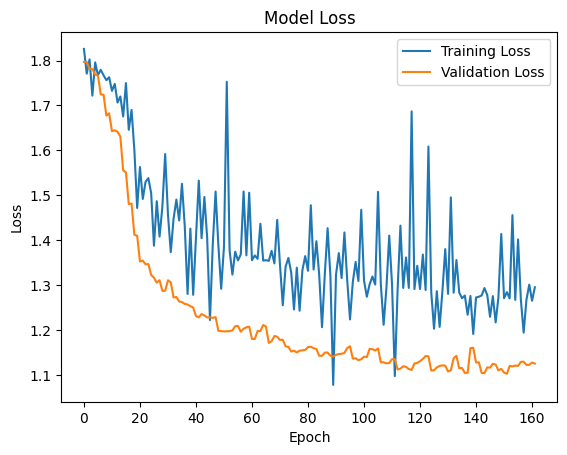

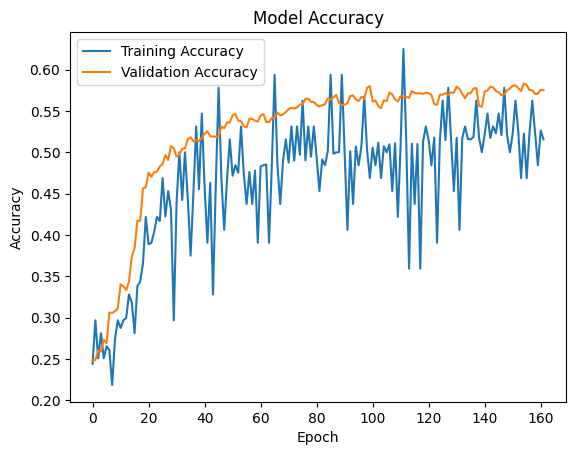

In [11]:
# prompt: plote as curvas de loss e acuracia de treinameto do modelo

import matplotlib.pyplot as plt
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.5816 - loss: 1.0889
Test accuracy: 0.591251015663147
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


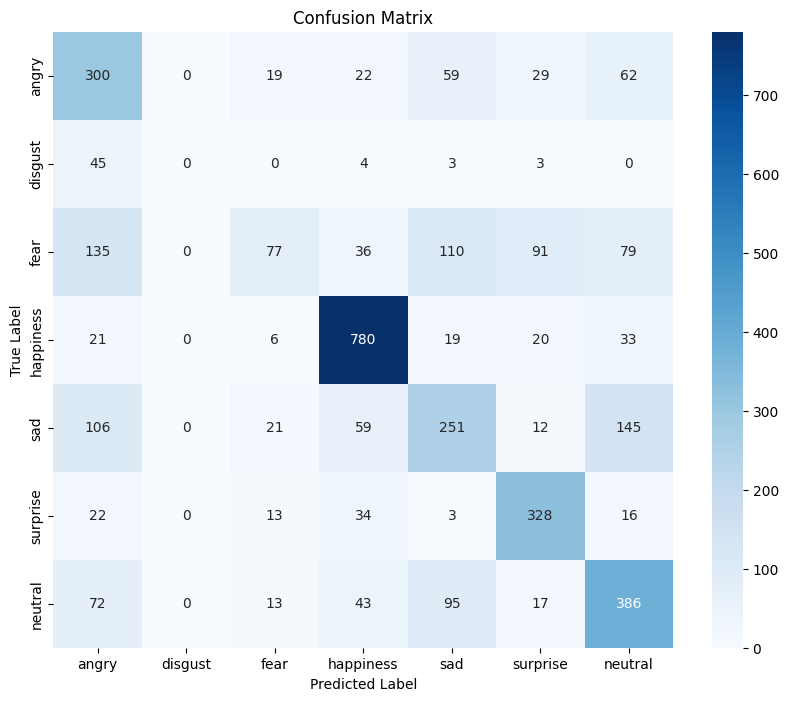

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Avaliação do modelo usando geradores
test_loss, test_acc = model.evaluate(x_test,y_test, steps=len(x_test) // 64)
print('Test accuracy:', test_acc)

# Previsões
y_pred = model.predict(x_test, steps=len(x_test) // 64)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Função para plotar a matriz de confusão
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plotar a matriz de confusão
plot_confusion_matrix(conf_matrix, classes=[label_to_text[i] for i in range(7)])


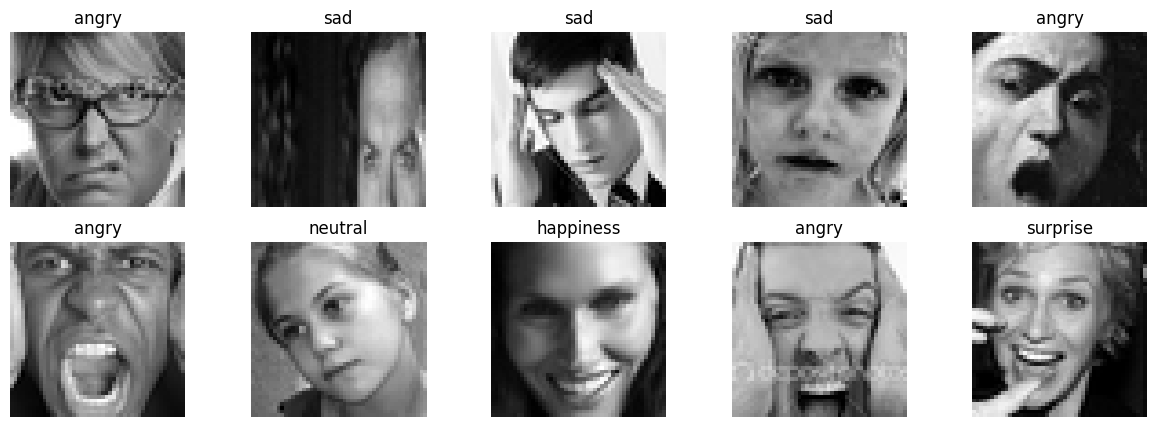

In [13]:
# Exibir 10 imagens de exemplo do conjunto de teste
show_sample_images(x_test, y_pred, num_images=10)